# Análise do uso das redes sociais pelas candidaturas (eleições municipais 2020)

[Voltar ao Índice](00_indice.ipynb)

Vamos realizar uma análise de estatística descritiva dos dados do TSE referentes ao uso de redes sociais pelas candidaturas. 
O objetivo é ter um panorama de quais são as redes sociais e recursos da web utilizados pelas candidaturas e as relações entre
esse uso e características das candidaturas.

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import scipy.stats as stats
import numpy as np
from importlib import reload
from pathlib import Path

import src.analysis_functions as af
import src.xavy.dataframes as xd
import src.xavy.stats as xx
import src.xavy.plots as xp
import src.xavy.data_retriever as xz

## Carregando os dados

Vamos produzir uma tabela com uma linha por candidato mostrando quais as plataformas utilizadas por cada um. Também vamos juntar a cada candidato diversas características suas e do eleitorado da sua unidade.

In [2]:
# Baixa dados caso ainda não estejam presentes:
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/2HGbHTrWmnLwqjr/download/consulta_cand_2020_BRASIL.zip', '../dados/limpos/tse/consulta_cand/', keep_zip_dir=False)
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/dq33a5KdTL3m6mn/download/perfil_eleitorado_2020.zip', '../dados/limpos/tse/perfil_eleitorado/', keep_zip_dir=False)
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/4SrtdWnNjmqDSzj/download/bem_candidato_2020_BRASIL.zip', '../dados/limpos/tse/bens_candidatos/', keep_zip_dir=False)
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/2cYcXDn2AqmsK4j/download/votacao_candidato_munzona_2020.zip', '../dados/brutos/tse/', keep_zip_dir=False)

# Carrega informações sobre o candidato, seus bens e sobre o número de eleitores na sua unidade eleitoral:
cand_df = af.load_cand_eleitorado_bens_votos('../dados/limpos/tse/consulta_cand/consulta_cand_2020_BRASIL.csv',
                                             '../dados/limpos/tse/perfil_eleitorado/perfil_eleitorado_2020.csv',
                                             '../dados/limpos/tse/bens_candidatos/bem_candidato_2020_BRASIL.csv',
                                             '../dados/brutos/tse/votacao_candidato_munzona_2020/votacao_candidato_munzona_2020_BRASIL.csv')

No local file found.
Unzipping file...
Files unzipped to ../dados/limpos/tse/consulta_cand/
No local file found.
Unzipping file...
Files unzipped to ../dados/limpos/tse/perfil_eleitorado/
No local file found.
Unzipping file...
Files unzipped to ../dados/limpos/tse/bens_candidatos/
Found a local file, skip download.


In [4]:
# Carrega listagem de redes sociais de candidatos (uma linha por candidato+rede):
platform_regex = af.return_redes_regex()
xz.sync_remote_zipped_files('https://nuvem.ceweb.br/s/zbyiMRJa7w66j74/download/rede_social_candidato_2020.zip', '../dados/brutos/tse/redes_sociais/', keep_zip_dir=False)
redes_df = af.etl_tse_redes_sociais('../dados/brutos/tse/redes_sociais/rede_social_candidato_2020.csv', platform_regex)

Found a local file, skip download.


In [5]:
# Cria tabela de uso de plataforma por usuário (uma linha por candidato):
redes_cols = list(platform_regex.keys()) + ['website', 'arroba', 'usuario']
use_df = af.platform_use_by_cand(cand_df, redes_df, redes_cols)
use_df['FRAC_VOTOS'] = use_df['QT_VOTOS_NOMINAIS'] / use_df['QT_ELEITORES_PERFIL'] * 1e8

## Análise

### Estimativa de taxa de "não declaração" de redes sociais

Os dados do TSE sobre as redes sociais dos candidatos são declarados livremente pelos partidos no ato do registro das candidaturas, então eles não são completos.
Para estimar a fração dos candidatos que não declararam redes mas as têm, **vamos utilizar o resultado da busca manual por perfis em redes sociais feita com candidaturas de 2022**.
Essa escolha se deve ao tempo transcorrido desde as eleições de 2020 e o presente estudo; a busca por perfis e websites das candidaturas de 2020 pode não ser acurada se realizada dois anos após as eleições.

Por se tratar de um processo de amostragem aleatório e independente da população de candidatos sem redes declaradas, o resultado segue uma distribuição binomial.

In [6]:
# Carregando resultado da busca sobre os candidatos acima (29/100 possuem redes):
manual_check_df = pd.read_csv(Path('../dados/processados/candidatos_sem_redes_declaradas_2022.csv'))
n_redes_ocultas = (manual_check_df['PLATAFORMA'] != 'Nenhuma').sum()
n_semredes = len(manual_check_df)

In [7]:
# Cálculo da probabilidade a posteriori da fração dos "sem rede" terem rede:
dp = 0.001
p, post = xx.triang_binom_posterior(0.7, n_semredes, n_redes_ocultas, dp)

# Cálculo do valor esperado e incerteza:
mean_p = (p * post * dp).sum()
mean_p2 = (p**2 * post * dp).sum()
dev_p = np.sqrt(mean_p2 - mean_p**2)

### Estimativa do uso das diferentes plataformas

A partir das redes declaradas ao TSE e da estimativa de redes não declaradas acima, vamos estimar a verdadeira presença das diversas plataformas nas candidaturas. Para tanto, vamos assumir as seguintes hipóteses:

1. Que a fração de candidaturas com redes sociais entre as que não declararam nenhuma é dada pelo valor esperado estimado acima;
2. Que as plataformas não declaradas se distribuem da mesma maneira que as declaradas, isto é, que a suas presenças nas candidaturas são todas corrigidas por um fator constante.

In [8]:
# Corrigindo os dados de uso de redes sociais pela fração estimada de redes não declaradas:
cand_per_platform = use_df[redes_cols].sum().sort_values()
cand_per_platform_fix = cand_per_platform.copy()
NTs = cand_per_platform_fix['nenhuma']
cand_per_platform_fix.loc['nenhuma'] = cand_per_platform_fix.loc['nenhuma'] * (1 - mean_p)
cand_per_platform_fix.loc[cand_per_platform_fix.index != 'nenhuma'] = cand_per_platform_fix.loc[cand_per_platform_fix.index != 'nenhuma'] * (1 + mean_p * NTs / (len(use_df) - NTs))

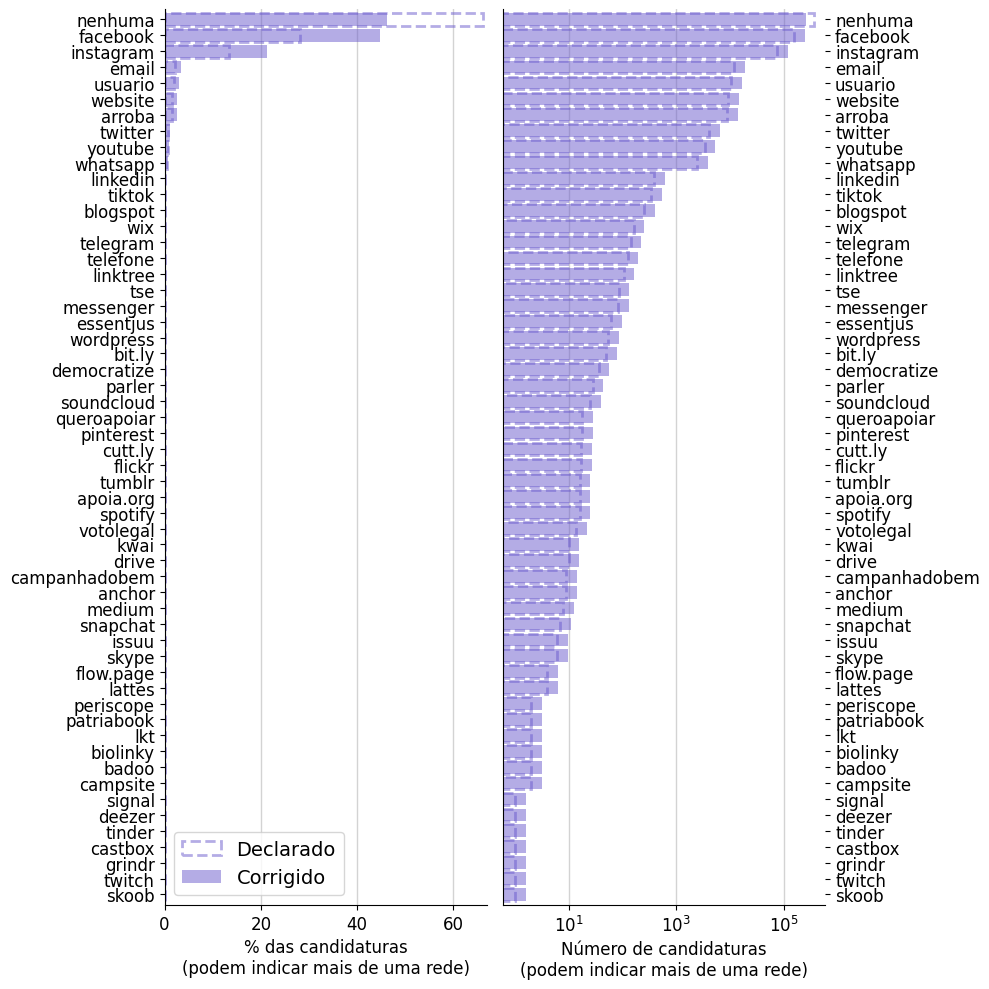

In [9]:
n_cands = len(use_df)
fig = af.plot_platform_counts(cand_per_platform, n_cands, facecolor='none', edgecolor='slateblue', linewidth=2, linestyle='--', alpha=0.5, label='Declarado')
fig = af.plot_platform_counts(cand_per_platform_fix, n_cands, labelsize=12, fig=fig, color='slateblue', alpha=0.5, label='Corrigido', lims=[(0, 67), (6e-1, 6e5)])
pl.subplot(1,2,1)
pl.legend(fontsize=14)
pl.tight_layout()
#pl.savefig(Path('../resultados/plots/plataformas-utilizadas_2020.png'))
pl.show()

Embora a hipótese 2 acima possa não ser exatamente válida, não acreditamos que uma eventual discrepância seja significativa a ponto de alterar a escala de grandeza da frequência de uso das diferentes plataformas. 

### Relação do uso de plataformas com dimensões dos candidatos

Vamos verificar como a declaração de cada plataforma está relacionada com as características dos candidatos.

#### Idade

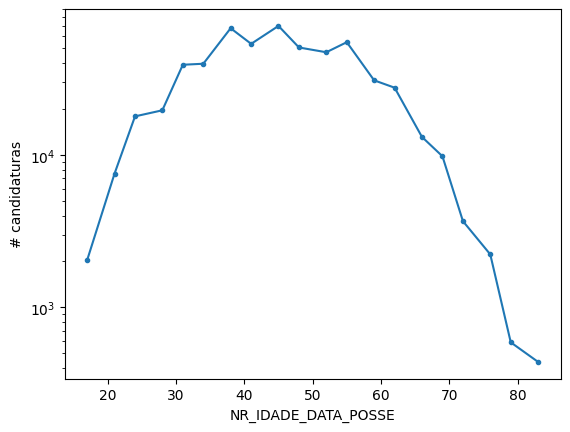

In [10]:
# Definindo os bins:
af.plot_bin_counts(use_df['NR_IDADE_DATA_POSSE'], 20, 16, 85)

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


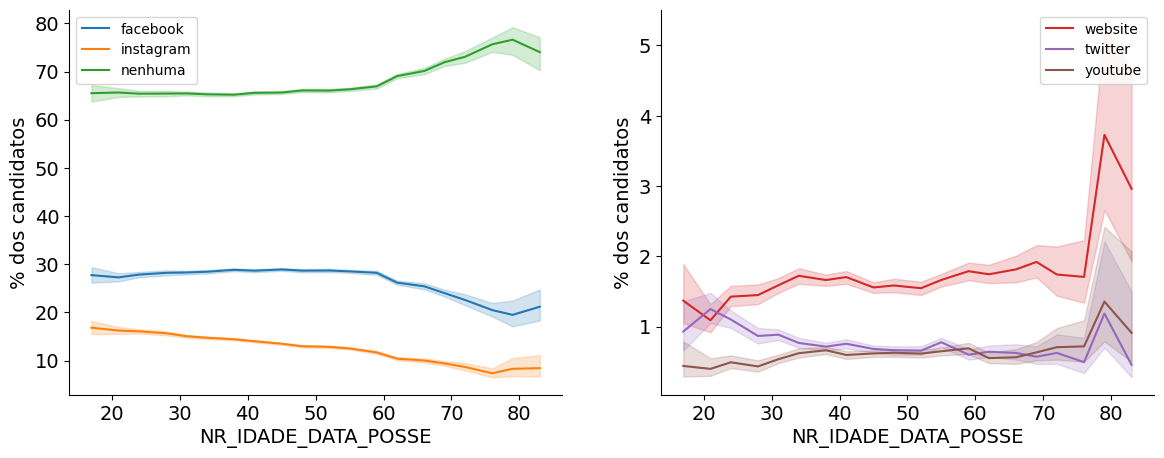

In [11]:
# Gráfico:
dim = 'NR_IDADE_DATA_POSSE'
n_bins = 20
lower_clip = 16
upper_clip = 85

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, n_bins, lower_clip, upper_clip)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, n_bins, lower_clip, upper_clip, coffset=3)
pl.show()

#### Bens declarados

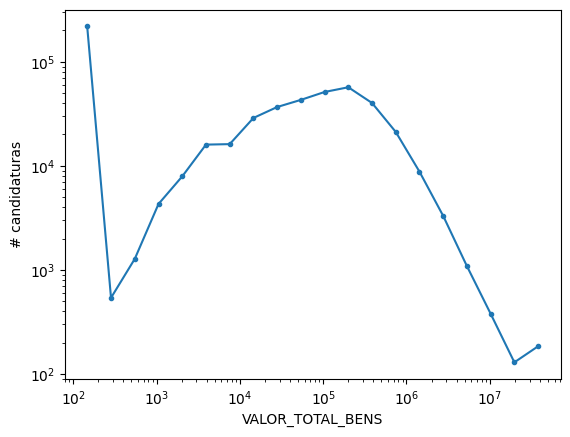

In [12]:
# Definindo os bins:
af.plot_bin_counts(use_df['VALOR_TOTAL_BENS'], 20, 101, 5e7, logscale=True)

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


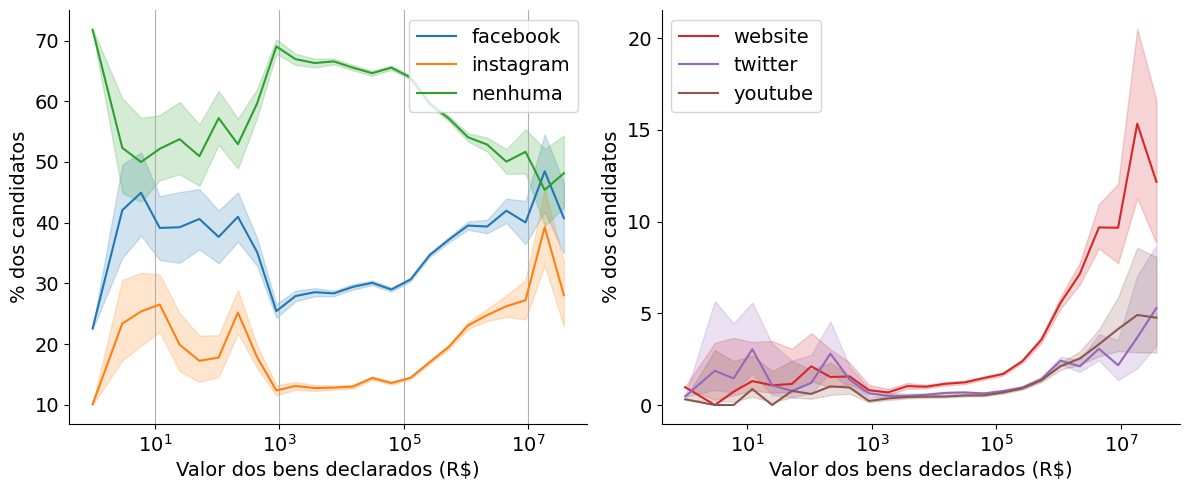

In [13]:
# Gráfico:
dim = 'VALOR_TOTAL_BENS'
n_bins = 25
lower_clip = 1
upper_clip = 5e7

pl.figure(figsize=(12,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, n_bins, lower_clip, upper_clip, legend_size=14, legend_loc='upper right', logscale=True, xlabel='Valor dos bens declarados (R$)')
#pl.axvline(500)
pl.grid(axis='x')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, n_bins, lower_clip, upper_clip, legend_size=14, legend_loc='upper left', coffset=3, logscale=True, xlabel='Valor dos bens declarados (R$)')
pl.tight_layout()
#pl.savefig(Path('../resultados/plots/uso-plataformas-por-dimensao_2020_bens.png'))
pl.show()

Investigando faixa de baixo (mas não nulo) patrimônio

In [14]:
import src.xavy.explore as xe

In [15]:
# Carregando dados sobre bens dos candidatos:
bens_df = pd.read_csv('../dados/limpos/tse/bens_candidatos/bem_candidato_2020_BRASIL.csv')
# Adicionando colunas com valores agregados por candidato:
n_bens  = bens_df['SQ_CANDIDATO'].value_counts()
n_bens.name = 'N_BENS'
v_bens = bens_df.groupby('SQ_CANDIDATO')['VR_BEM_CANDIDATO'].sum()
v_bens.name = 'VALOR_TOTAL'
bens_df = bens_df.join(n_bens, on='SQ_CANDIDATO').join(v_bens, on='SQ_CANDIDATO')

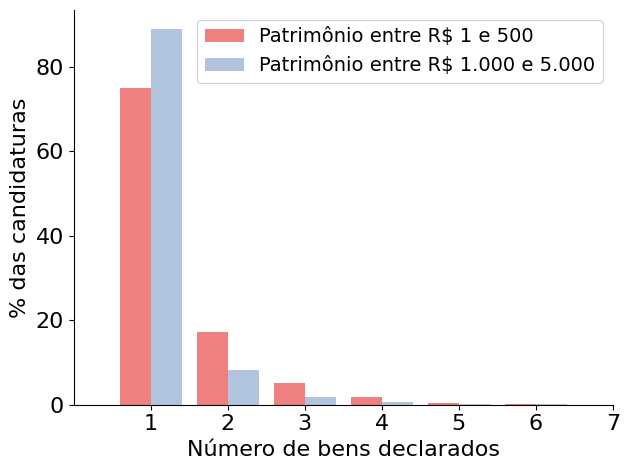

In [16]:
# Contabilizando número de candidatos por número de bens declarados para duas faixas de patrimônio:

bens_low_df = bens_df.query('(VALOR_TOTAL > 1) and (VALOR_TOTAL < 500)')
bem_counts_low = bens_low_df.drop_duplicates(subset='SQ_CANDIDATO')['N_BENS'].value_counts()
n_cand_low = bem_counts_low.sum()
bem_counts_low = bem_counts_low / n_cand_low * 100
bem_counts_low.name = 'Patrimônio entre R$ 1 e 500'

bens_high_df = bens_df.query('(VALOR_TOTAL > 1000) and (VALOR_TOTAL < 5000)')
bem_counts_high = bens_high_df.drop_duplicates(subset='SQ_CANDIDATO')['N_BENS'].value_counts()
n_cand_high = bem_counts_high.sum()
bem_counts_high = bem_counts_high / n_cand_high * 100
bem_counts_high.name = 'Patrimônio entre R$ 1.000 e 5.000'

max_bem_counts = max(bem_counts_low.index.max(), bem_counts_high.index.max())
n_bens_hist_df = pd.DataFrame(index=range(1, max_bem_counts + 1))
n_bens_hist_df.index.name = 'n_bens'
n_bens_hist_df = n_bens_hist_df.join(bem_counts_low).join(bem_counts_high).fillna(0)

# Gráfico da contagem de candidaturas por número de bens declarados:
xp.multiple_bars_plot(n_bens_hist_df, colors=['lightcoral', 'lightsteelblue'])
pl.xlim([-1,6])
pl.ylabel('% das candidaturas', fontsize=16)
pl.xlabel('Número de bens declarados', fontsize=16)
pl.tick_params(labelsize=16)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.legend(fontsize=14)
pl.tight_layout()
#pl.savefig(Path('../resultados/plots/hist_n_bens_por_valor_total_2020.png'))
pl.show()

Para termos uma medida quantitativa do zelo e investimento das candidaturas com a declaração de bens, vamos verificar o nível de detalhe utilizado na descrição dos bens.
A ideia é que, quanto mais detalhado, maior a preocupação em fazer uma boa declaração e não simplesmente cumprir uma obrigação burocrática.

Primeiro, assumimos que se as declarações apresentam mais detalhes, elas terão um vocabulário mais rico. Por exemplo, elas podem descrever o modelo de um veículo, 
a localização de um imóvel e o número de uma conta bancária ao invés de utilizar apenas termos genéricos. Então vamos comparar o tamanho do vocabulário utilizado 
nas declarações de candidatos com baixo valor total de bens com amostras de mesmo número de declarações de bens, sorteadas de candidaturas com maior valor total de bens.

In [17]:
len(bens_low_df)

3162

In [18]:
n_tokens_low = af.vocab_size(bens_low_df['DS_BEM_CANDIDATO'])
n_tokens_high_sample = np.array([af.vocab_size(bens_high_df['DS_BEM_CANDIDATO'].sample(len(bens_low_df))) for _ in range(4000)])

In [19]:
print(xd.bold('Candidatos com patrimônio < R$ 500'))
print('Tamanho do vocabulário: {:.0f}'.format(n_tokens_low))

print(xd.bold('Candidatos com patrimônio > R$ 1.000'))
print('Tamanho médio do vocabulário: {:.0f}'.format(n_tokens_high_sample.mean()))
print('Desvio do tamanho do vocabulário: {:.0f}'.format(n_tokens_high_sample.std()))
print('Tamanho máximo do vocabulário: {:.0f}'.format(n_tokens_high_sample.max()))

Candidatos com patrimônio < R$ 500
Tamanho do vocabulário: 3456
Candidatos com patrimônio > R$ 1.000
Tamanho médio do vocabulário: 2632
Desvio do tamanho do vocabulário: 60
Tamanho máximo do vocabulário: 2830


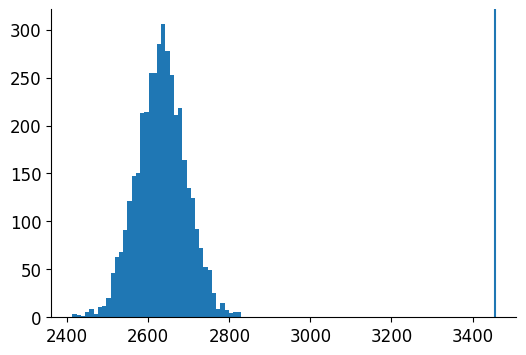

In [20]:
pl.figure(figsize=(6,4))
pl.hist(n_tokens_high_sample, bins=40)
pl.axvline(n_tokens_low)
# Format:
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tick_params(labelsize=12)
pl.show()

Outra forma de verificar o nível de detalhe das descrições dos bens é contar o número de palavras utilizadas em cada uma. Faremos isso abaixo e compararemos a distribuição da contagem para candidaturas com baixo e alto patrimônio: 

In [21]:
# Count the number of words in each description:
n_tokens_per_bem_low  = bens_low_df['DS_BEM_CANDIDATO'].fillna('').str.split().str.len()
n_tokens_per_bem_high = bens_high_df['DS_BEM_CANDIDATO'].fillna('').str.split().str.len()

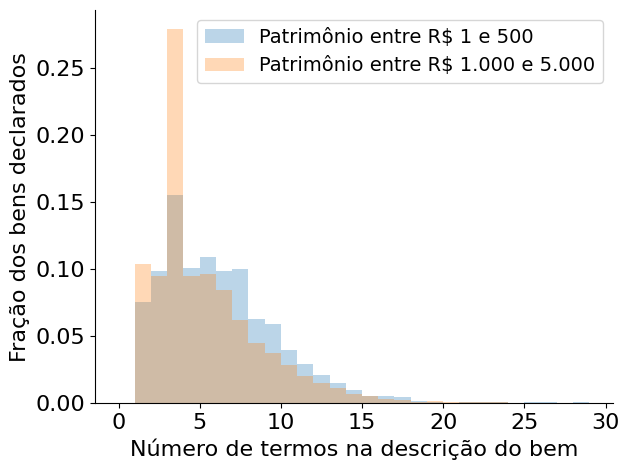

In [23]:
pl.hist(n_tokens_per_bem_low, bins=range(0,30), density=True, label='Patrimônio entre R$ 1 e 500', alpha=0.3)
pl.hist(n_tokens_per_bem_high, bins=range(0,30), density=True, label='Patrimônio entre R$ 1.000 e 5.000', alpha=0.3)
pl.legend(fontsize=14)
# Format:
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.tick_params(labelsize=16)
pl.xlabel('Número de termos na descrição do bem', fontsize=16)
pl.ylabel('Fração dos bens declarados', fontsize=16)
pl.tight_layout()
#pl.savefig(Path('../resultados/plots/hist_palavras_descricao_bens_por_valor_total_2020.png'))
pl.show()

#### Quantidade de votos

No caso da quantidade de votos obtidos, os cargos aos quais os candidatos estão concorrendo pode distorcer a análise: cargos majoritários (senadores, presidentes, governadores) tendem a ter muito mais votos do que cargos proporcionais (deputados), mesmo se ponderarmos pelo tamanho do colégio eleitoral (para retirar efeitos de unidades com eleitorados de tamanhos muito diferentes). Por isso, faremos a análise apenas para deputados.

In [24]:
# Seleção dos deputados:
deps_use_df = use_df.loc[use_df['DS_CARGO'].isin(['VEREADOR'])]

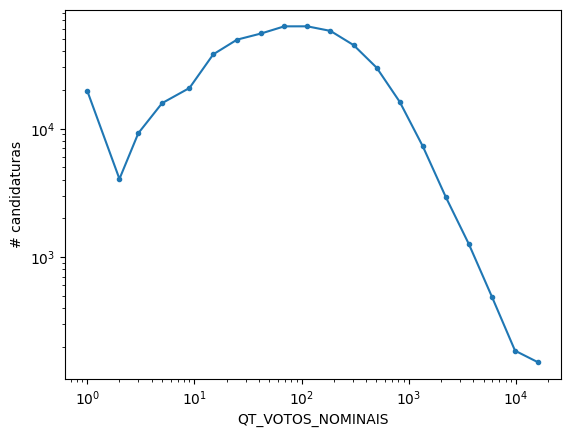

In [25]:
# Definindo os bins:
af.plot_bin_counts(deps_use_df['QT_VOTOS_NOMINAIS'], 20, 1, 2e4, logscale=True)

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


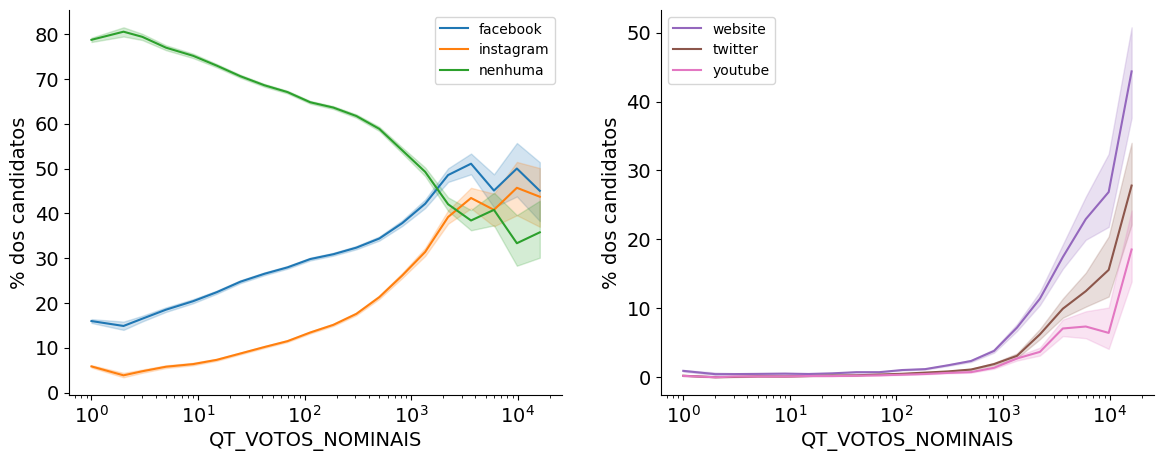

In [26]:
# Gráfico:
dim = 'QT_VOTOS_NOMINAIS'
n_bins = 20
lower_clip = 1
upper_clip = 2e4

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(deps_use_df, ['facebook', 'instagram', 'nenhuma'], dim, n_bins, lower_clip, upper_clip, logscale=True)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(deps_use_df, ['website', 'twitter', 'youtube'], dim, n_bins, lower_clip, upper_clip, coffset=4, logscale=True)
pl.show()

O resultado acima não compara os candidatos em termos de popularidade na sua unidade eleitoral, pois existem unidades com mais eleitores do que outras.
Para isolar esse efeito, vamos verificar o uso das plataformas em função de um número de eleitores de referência, de 100 milhões. 

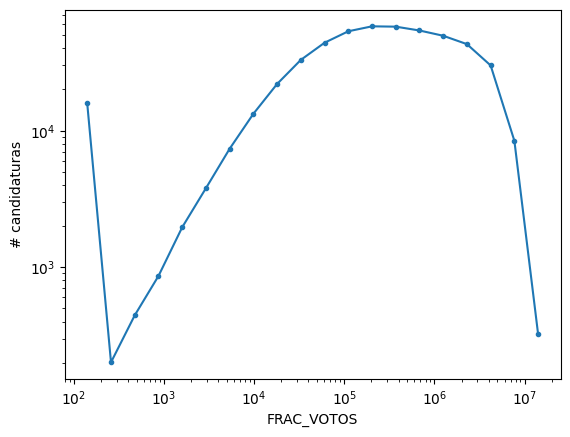

In [27]:
# Definindo os bins:
af.plot_bin_counts(deps_use_df['FRAC_VOTOS'], 20, 100, 1e8, logscale=True)

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


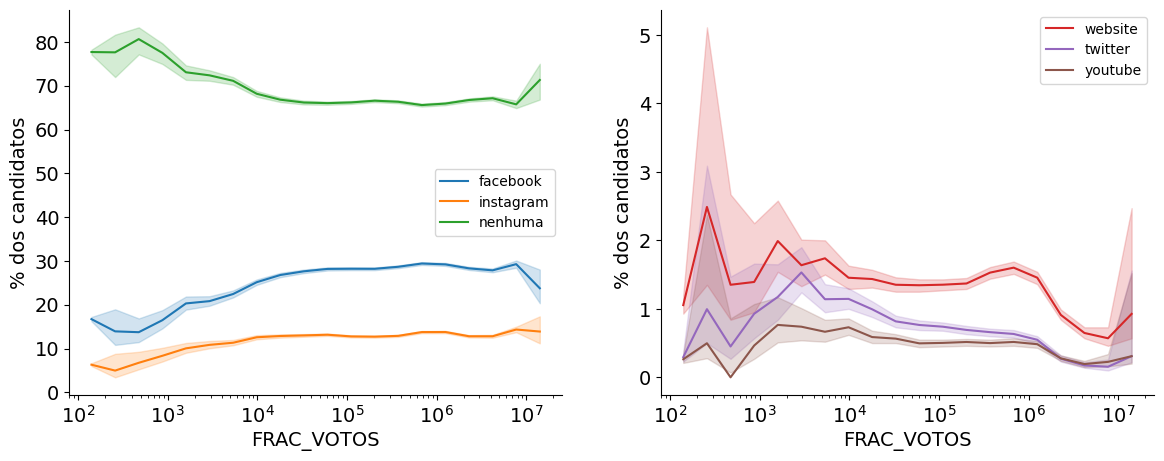

In [28]:
# Gráfico:
dim = 'FRAC_VOTOS'
n_bins = 20
lower_clip = 100
upper_clip = 1e8

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(deps_use_df, ['facebook', 'instagram', 'nenhuma'], dim, n_bins, lower_clip, upper_clip, logscale=True)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(deps_use_df, ['website', 'twitter', 'youtube'], dim, n_bins, lower_clip, upper_clip, coffset=3, logscale=True)
pl.show()

#### Quantidade de eleitores

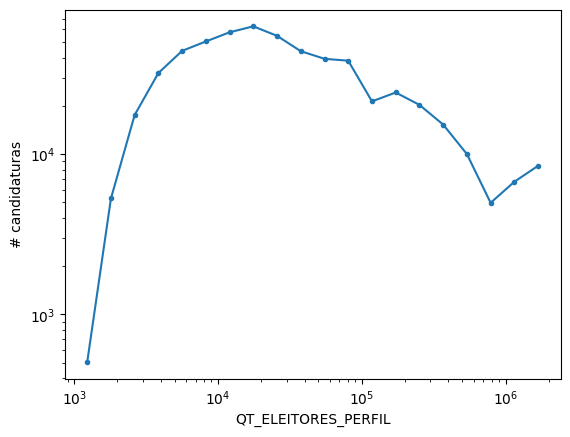

In [29]:
# Definindo os bins:
af.plot_bin_counts(use_df['QT_ELEITORES_PERFIL'], 20, 1000, 2e6, logscale=True)

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


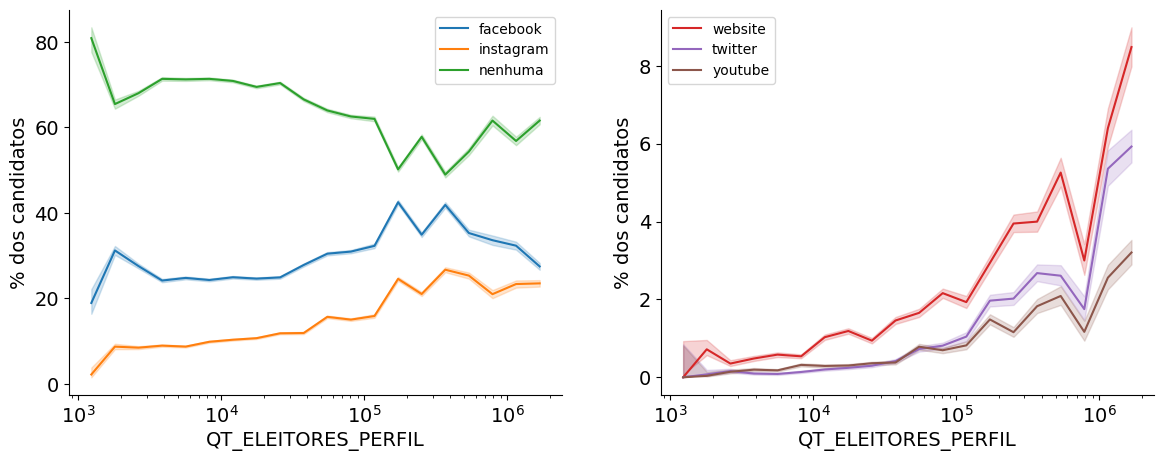

In [30]:
# Gráfico:
dim = 'QT_ELEITORES_PERFIL'
n_bins = 20
lower_clip = 1000
upper_clip = 2e6

pl.figure(figsize=(14,5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, n_bins, lower_clip, upper_clip, logscale=True)
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, n_bins, lower_clip, upper_clip, coffset=3, logscale=True)
pl.show()

#### Cor/raça

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


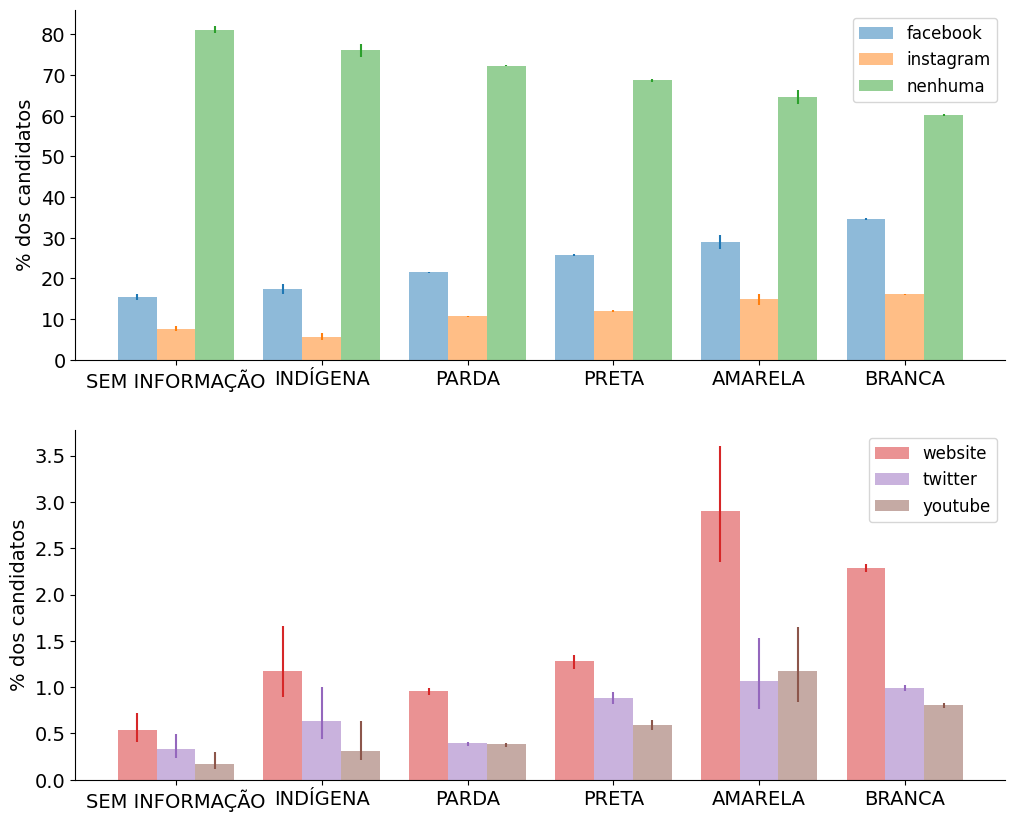

In [31]:
dim = 'DS_COR_RACA'
categories = ['SEM INFORMAÇÃO', 'INDÍGENA', 'PARDA', 'PRETA', 'AMARELA', 'BRANCA']

pl.figure(figsize=(12, 10))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, categories, legend_size=12)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, categories, coffset=3, legend_size=12)
pl.show()

#### Gênero

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


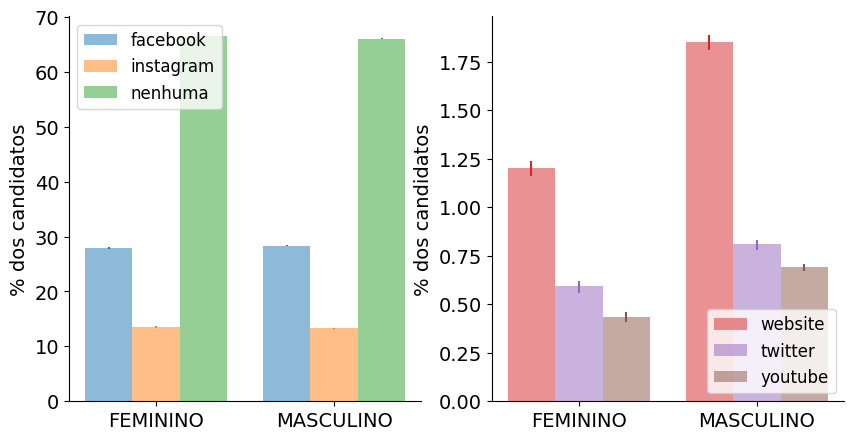

In [32]:
dim = 'DS_GENERO'
categories = ['FEMININO', 'MASCULINO']

pl.figure(figsize=(10, 5))
pl.subplot(1,2,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, categories, legend_size=12, legend_loc='upper left')
pl.subplot(1,2,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, categories, coffset=3, legend_size=12, legend_loc='lower right')
pl.show()

#### Escolaridade

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


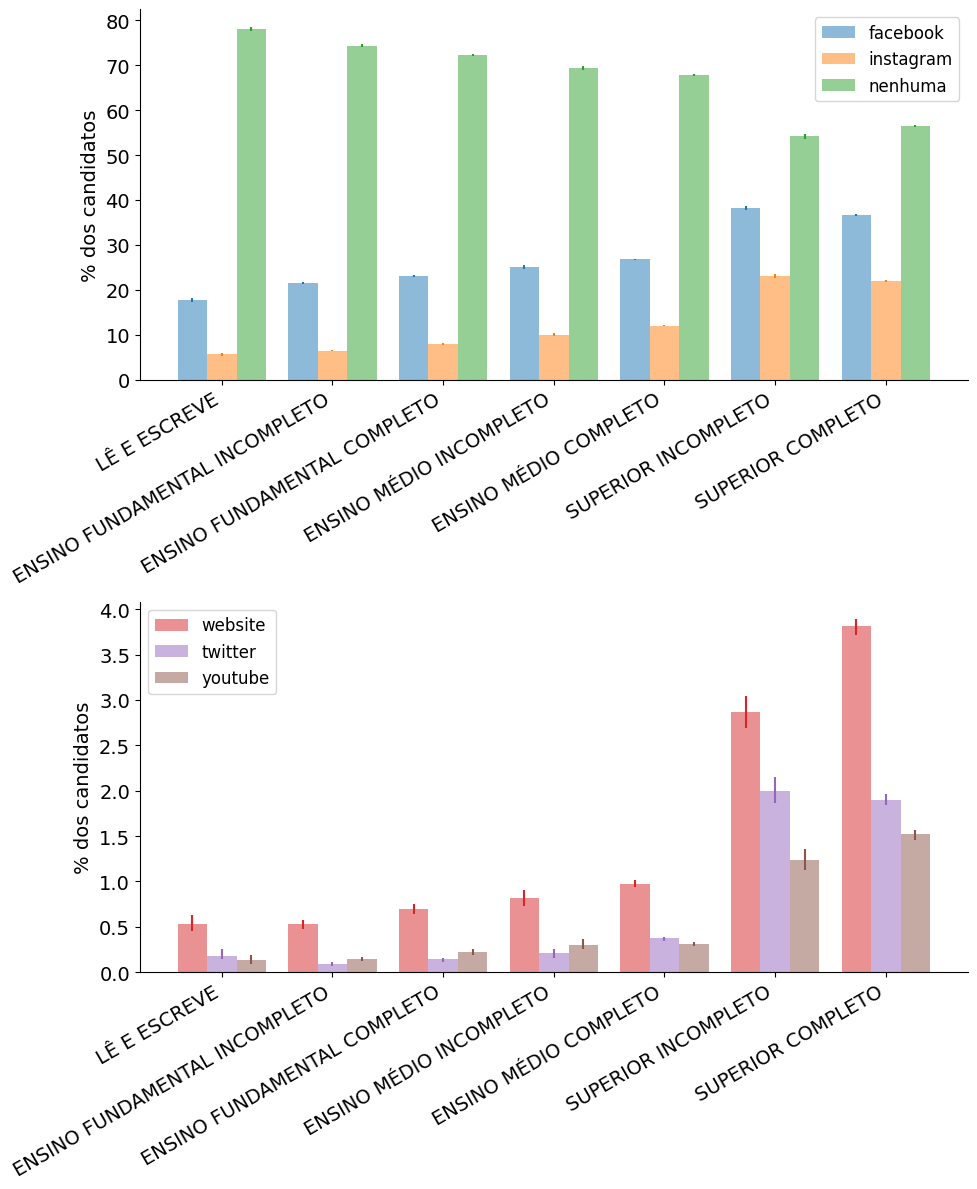

In [33]:
dim = 'DS_GRAU_INSTRUCAO'
categories = ['LÊ E ESCREVE', 'ENSINO FUNDAMENTAL INCOMPLETO', 'ENSINO FUNDAMENTAL COMPLETO', 'ENSINO MÉDIO INCOMPLETO', 'ENSINO MÉDIO COMPLETO', 'SUPERIOR INCOMPLETO', 'SUPERIOR COMPLETO']

pl.figure(figsize=(10, 12))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, categories, legend_size=12, label_rot=30)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, categories, coffset=3, legend_size=12, label_rot=30)
pl.tight_layout()
pl.show()

#### Cargo

/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)
/home/hxavier/temp/violentometro/env/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:77: RuntimeWarning: divide by zero encountered in _binom_pdf
  return _boost._binom_pdf(x, n, p)


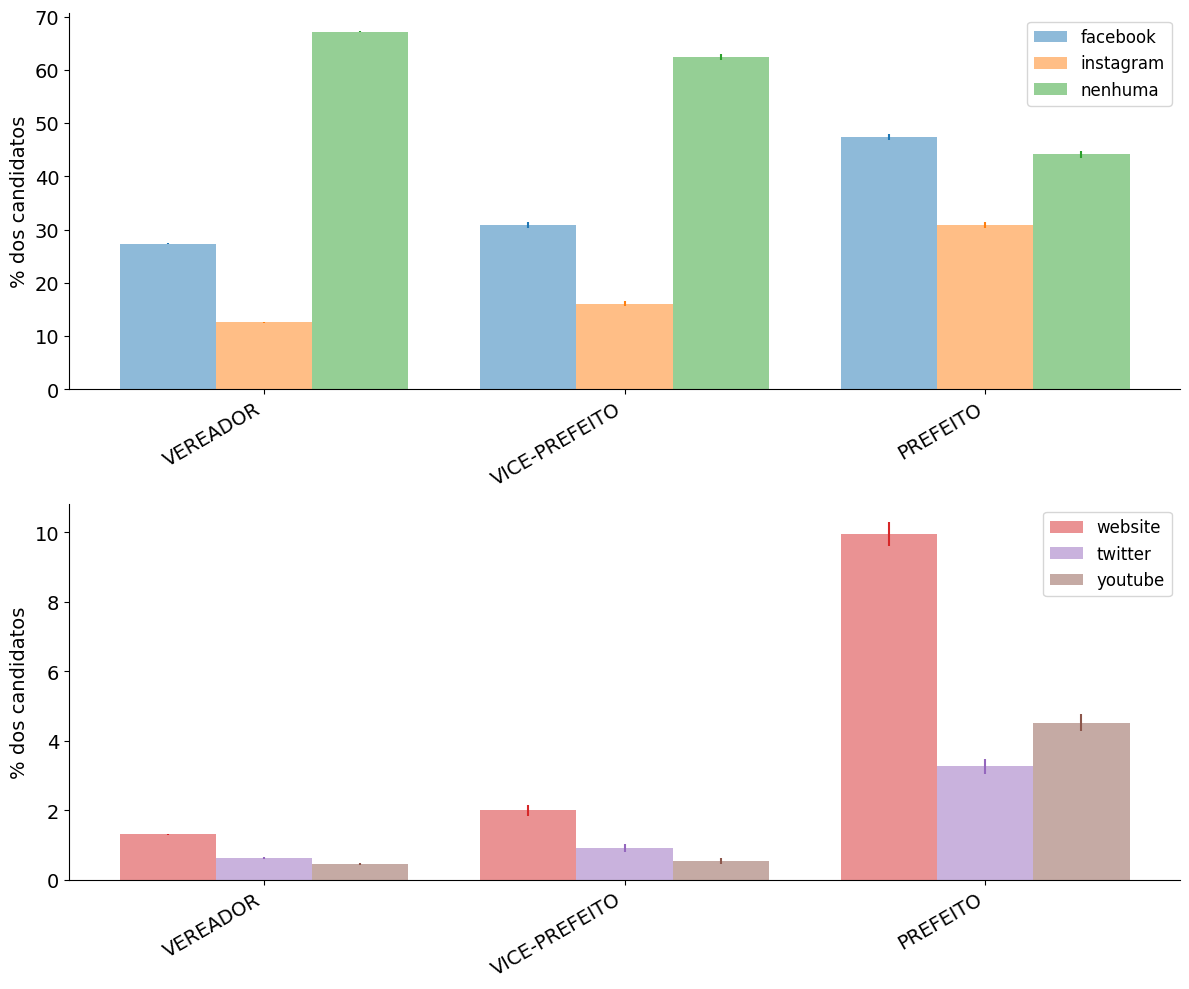

In [34]:
dim = 'DS_CARGO'
categories = ['VEREADOR', 'VICE-PREFEITO', 'PREFEITO']

pl.figure(figsize=(12, 10))
pl.subplot(2,1,1)
af.plot_usage_frac_by_dimension(use_df, ['facebook', 'instagram', 'nenhuma'], dim, categories, legend_size=12, label_rot=30)
pl.subplot(2,1,2)
af.plot_usage_frac_by_dimension(use_df, ['website', 'twitter', 'youtube'], dim, categories, coffset=3, legend_size=12, label_rot=30)
pl.tight_layout()
pl.show()